<a href="https://colab.research.google.com/github/mpmatthe/evomap/blob/main/docs/evomap_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install evomap

# About

This script presents a quick tutorial as a companion to the paper: 'evomap - a Toolbox for Dynamic Mapping in Python'.

All code was last run on GoogleCoLab using Python version 3.11.0 evomap version 0.4.6


# Setup

In [2]:

# First, create path variabels for each subfolder and import the essential packages.

import time

start_time = time.time()

import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import os



In [3]:
save_to = False # Options: 'local', 'drive'

if save_to == 'local':
    PATH_HOME = os.path.dirname(os.path.dirname(os.path.abspath(__file__))) # parent folder
    PATH_OUT = os.path.join(PATH_HOME, 'gen') # output folder
    if not os.path.exists(PATH_OUT):
        os.makedirs(PATH_OUT)

    # Clear /gen folder of output from previous runs
    for file in os.listdir(PATH_OUT):
        os.remove(os.path.join(PATH_OUT, file))

elif save_to == 'drive':
	current_path = '/content/drive/My Drive/Colab Notebooks'
	from google.colab import drive
	import sys
	drive.mount('/content/drive')
	sys.path.append(current_path)
elif save_to == False:
     print('No figures will be saved')


No figures will be saved


In [4]:
# Plotting parameters
title_fontdict = {'size': 20, 'family': 'sans-serif'}
title_fontdict_large = {'size': 22, 'family': 'sans-serif'}
label_fontdict = {'size': 18, 'family': 'sans-serif'}
label_fontdict_large = {'size': 20, 'family': 'sans-serif'}


In [5]:
# Set random seed for reproducibility
np.random.seed(111)

# Part 1: Illustration of Static vs. Dynamic Mapping

The following code presents an illustration of static mapping.

## Loading the Data

The TNIC dataset captures firm–firm relationships based on the linguistic similarity of
product descriptions in annual reports. The data consist of a time-indexed edgelist,
where each row represents a pair of firms at a given time, including their names, a
similarity score, and a standardized identifier that can be used to link firms to additional
information (e.g., their Standard Industrial Classification (SIC) codes or market size).
Intuitively, the similarity score indicates product-market similarity—that is, the degree to
which two firms compete by offering related products or services. As such, TNIC similarity
scores can be interpreted as measures of competitive proximity, which—through mapping
techniques—can reveal firms' underlying spatial positions in the market. For further
information on the TNIC dataset, we refer to Hoberg & Phillips (2016).

In [6]:
# For most of this illustration, we use a small sample from the TNIC data available through the dataset submodule.
from evomap.datasets import load_tnic_sample_tech
data = load_tnic_sample_tech()
display(data)

# The sample is organized as an edgelist where each observation corresponds to a single firm-firm pair.
# It contains a total of 9 firms and their pairiwse relationships over 20 years.
print(data.groupby('name1').agg({'year':'nunique'}))

,year,name1,name2,score,sic1,sic2,size1,size2,gvkey1,gvkey2
0,1998,APPLE INC,WESTERN DIGITAL CORP,0.0657,36,35,71.792988,32.294908,1690,11399
1,1998,APPLE INC,MICROSOFT CORP,0.0601,36,73,71.792988,517.384045,1690,12141
2,1998,APPLE INC,ORACLE CORP,0.0355,36,73,71.792988,188.441005,1690,12142
3,1998,AT&T INC,US CELLULAR CORP,0.0761,48,48,324.142356,57.620292,9899,14369
4,1998,EBAY INC,MICROSOFT CORP,0.0281,73,73,98.544590,517.384045,114524,12141
...,...,...,...,...,...,...,...,...,...,...
437,2017,ORACLE CORP,MICROSOFT CORP,0.1292,73,73,432.134053,728.911819,12142,12141
438,2017,ORACLE CORP,INTUIT INC,0.0231,73,73,432.134053,187.297107,12142,27928
439,2017,US CELLULAR CORP,AT&T INC,0.0184,48,48,56.555725,488.570204,14369,9899
440,2017,WESTERN DIGITAL CORP,APPLE INC,0.0321,35,36,161.395167,888.847624,11399,1690


                       year
name1                      
APPLE INC                20
AT&T INC                 20
EBAY INC                 20
INTUIT INC               20
MICRON TECHNOLOGY INC    20
MICROSOFT CORP           20
ORACLE CORP              20
US CELLULAR CORP         20
WESTERN DIGITAL CORP     20


In [7]:
# First, transform the edgelist into a sequence of similarity matrices
from evomap.preprocessing import edgelist2matrices
S_t, labels_t = edgelist2matrices(
    data,
    score_var = 'score',
    id_var_i = 'name1',
    id_var_j = 'name2',
    time_var = 'year')

# The result is a sequence of matrices and a sequence of labels.
# As the sample is balanced, all labels remain the same over time in this example.
# Therefore, we simply use the first list of labels in what follows.
labels = labels_t[0]
print(labels)

# Preview of a single similarity matrix:
print(S_t[0].round(2))

# To map this similarity matrix via MDS, we first transform it into dissimilarities using the sim2diss function
# from the preprocessing submodule.
from evomap.preprocessing import sim2diss
D_t = [sim2diss(S, transformation = 'mirror') for S in S_t]



['APPLE INC' 'AT&T INC' 'EBAY INC' 'INTUIT INC' 'MICRON TECHNOLOGY INC'
 'MICROSOFT CORP' 'ORACLE CORP' 'US CELLULAR CORP' 'WESTERN DIGITAL CORP']
[[0.   0.   0.   0.   0.   0.06 0.04 0.   0.07]
 [0.   0.   0.   0.   0.   0.   0.   0.08 0.  ]
 [0.   0.   0.   0.09 0.   0.03 0.   0.   0.  ]
 [0.   0.   0.09 0.   0.   0.05 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.03]
 [0.06 0.   0.03 0.05 0.   0.   0.1  0.   0.03]
 [0.04 0.   0.   0.   0.   0.1  0.   0.   0.03]
 [0.   0.08 0.   0.   0.   0.   0.   0.   0.  ]
 [0.07 0.   0.   0.   0.03 0.03 0.03 0.   0.  ]]


## Illustration of Static Mapping

In [8]:
# Next, we create static snapshots of these matrices using MDS.
periods = data.year.unique()
n_periods = len(periods)
n_samples = len(labels)
D_0 = D_t[0]
print("First snapshot corresponds to the year {0}".format(periods[0]))

First snapshot corresponds to the year 1998


In [9]:
# Here, we use non-metric ordinal MDS, initialized via Classical Scaling.
from evomap.mapping import MDS
mds = MDS(mds_type = 'ordinal', init = 'cmds', verbose = 1)
X_0 = mds.fit_transform(D_0)

[MDS] Running Gradient Descent with Backtracking via Halving
[MDS] Iteration 24: gradient norm vanished. Final cost: 0.14


The output of static mapping (here: MDS) is a $nxd$ point configuration, where n equals the number of objects (here: 9) and $d$ the dimensionality of the output space (typically, $d=2$)

In [10]:
X_0

array([[-0.53358889, -0.2804262 ],
       [ 0.78170097, -0.03525739],
       [ 0.05851682,  0.72124402],
       [-0.07774511,  0.63358509],
       [ 0.17503716, -0.7887548 ],
       [-0.38730869,  0.20067871],
       [-0.49654662,  0.05629126],
       [ 0.78170097, -0.03525739],
       [-0.30176662, -0.47210328]])

Final Stress value: 0.14


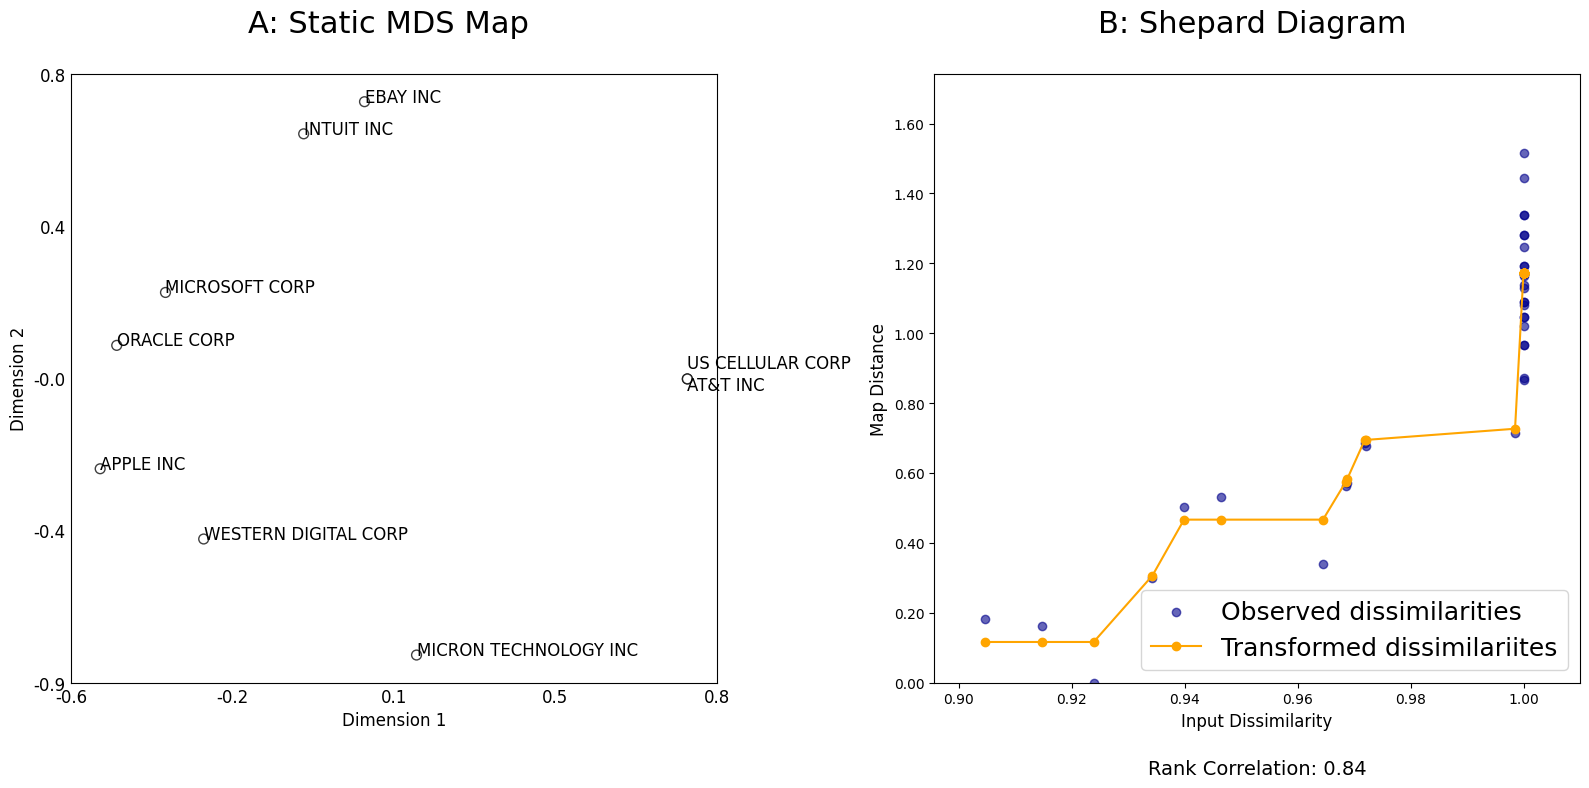

In [11]:
# To display the results, first draw a single snapshot.
from matplotlib import pyplot as plt
from evomap.printer import draw_map
fig, ax = plt.subplots(1,2, figsize = (16,8))
draw_map(
    X_0,
    label = labels,
    show_axes = True,
    axes_at_origin = False,
    show_grid = False,
    ax = ax[0])
ax[0].set_title('A: Static MDS Map \n', fontdict= title_fontdict_large)

# Wiggle labels a bit for AT&T and US CELLUAR to prevent overlap
offset_x = 0.0
offset_y = 0.03
texts = ax[0].texts
for text in texts:
    label_text = text.get_text()
    if label_text == 'US CELLULAR CORP':
        x, y = text.get_position()
        text.set_position((x + offset_x, y + offset_y))
    elif label_text == 'AT&T INC':
        x, y = text.get_position()
        text.set_position((x + offset_x, y - offset_y))

# Then, add the Shepard diagram to evaluate the snapshot's mapping quality.
from evomap.printer import draw_shepard_diagram
draw_shepard_diagram(X_0, D_0, ax = ax[1])
ax[1].set_title('B: Shepard Diagram \n', fontdict= title_fontdict_large)
ax[1].legend(['Observed dissimilarities', 'Transformed dissimilariites'], loc = 4, prop = label_fontdict)
fig.tight_layout()
print("Final Stress value: {0:.2f}".format(mds.cost_))
fig.show()

if save_to:
    fig.savefig(os.path.join(PATH_OUT, 'Fig1_static_mapping.PNG'), dpi = 300)

fig

## Dynamic Mapping via EvoMap

20
(9, 9)
20
(9, 2)
The maps represent the evolving positions over 20 years between 1998 and 2017


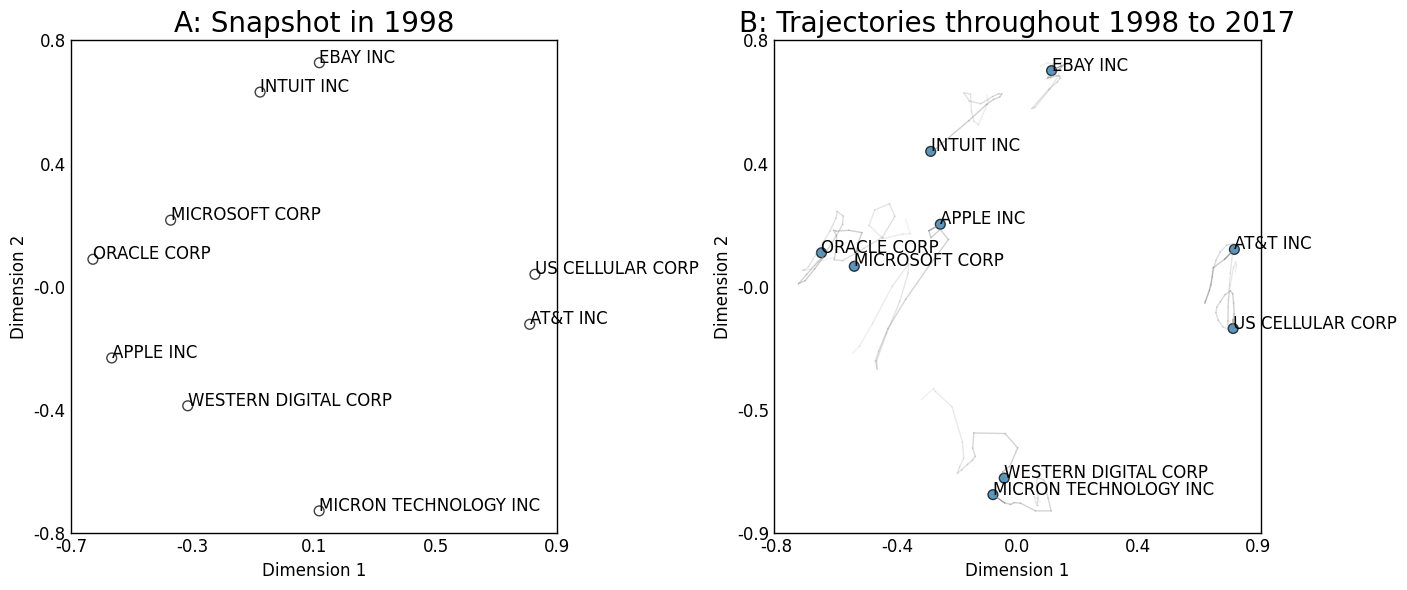

In [12]:
# To illustrate Dynamic Mapping, we apply EvoMap, implemented for MDS, to the entire sequence of matrices.
#
# The input data consists of a sequence of 20 dissimilarity matrices, each of shape (9,9)
print(len(D_t))
print(D_t[0].shape)

# First, we generate a sequence of starting configurations using Classical Scaling applied to the first period.
from evomap.mapping import CMDS
cmds_t = []
cmds = CMDS().fit_transform(D_t[0])
for t in range(n_periods):
    cmds_t.append(cmds)

# Then, we apply EvoMap. Here, we set the alignment penalty (alpha) to .2, and add some smoothing by increasing p to 2:
from evomap.mapping import EvoMDS
evomds = EvoMDS(
    alpha = .2,
    p = 2,
    mds_type = 'ordinal',
    init = cmds_t)
X_t = evomds.fit_transform(D_t)

print(len(X_t))
print(X_t[0].shape)

fig, ax = plt.subplots(1,2, figsize = (14, 6))
draw_map(X_t[0], label = labels, show_axes=True, show_box = True, ax = ax[0])

from evomap.printer import draw_dynamic_map
draw_dynamic_map(X_t,
                 label=labels,
                 show_axes=True,
                 show_last_positions_only=True,
                 show_arrows=True,
                 ax = ax[1])

ax[0].set_title('A: Snapshot in {}'.format(periods[0]), fontdict = title_fontdict)
ax[1].set_title('B: Trajectories throughout {0} to {1}'.format(periods[0], periods[-1]), fontdict = title_fontdict)

fig.tight_layout()
plt.show()


if save_to:
    fig.savefig(os.path.join(PATH_OUT, 'Fig2_dynamic_mapping.PNG'), dpi = 300)
print("The maps represent the evolving positions over {0} years between {1} and {2}".format(n_periods, periods[0], periods[-1]))
fig

# Part 2: Detailed Usage Example

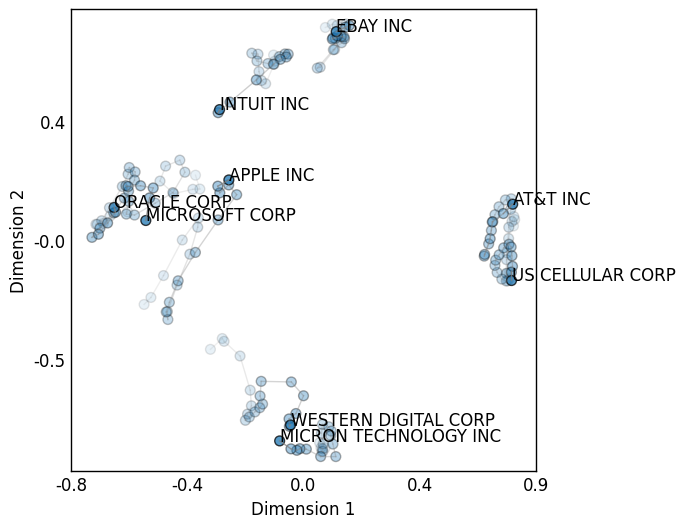

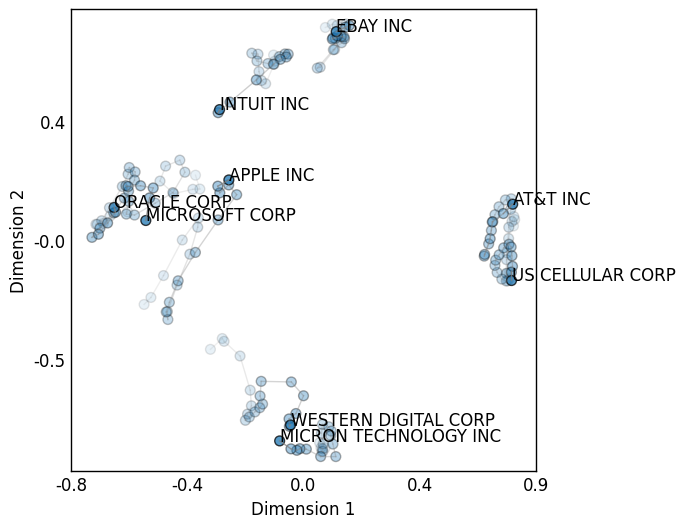

In [13]:
# This part goes through each step performed above in more detail.

# ## Basic Syntax
#
# The basic usecase of EvoMap is creating dynamic maps of evolving relationship data, like the following:
evomds = EvoMDS(
    alpha = .2,
    p = 2,
    mds_type = 'ordinal',
    init = cmds_t)
X_t = evomds.fit_transform(D_t)

draw_dynamic_map(X_t,
                 label=labels,
                 show_arrows=True,
                 show_axes=True)

fig, ax = plt.subplots(figsize = (6,6))
draw_dynamic_map(X_t, label = labels, show_arrows= True, show_axes = True, ax = ax)
plt.show()
if save_to:
    fig.savefig(os.path.join(PATH_OUT, 'Fig3_dynamic_map.PNG'), dpi = 300)
fig

## Preprocessing

In [14]:

# Before applying EvoMap, all input data needs to be formatted as a sequence of square matrices.
#
# Here, our data is represented as an edgelist:
table_overview = pd.concat([data.head(), data.tail()], axis = 0)
table_overview = table_overview[['year', 'name1', 'name2', 'score', 'sic1', 'sic2', 'size1', 'size2']]
table_overview.size1 = table_overview.size1.round(2)
table_overview.size2 = table_overview.size2.round(2)
print(table_overview)

# The basic syntax to use evomap consists of the following lines of code, which instantinates the method and fits it to the data. Note that the import statement is not necessary here, as we imported the class before, but only included for completeness of this minimal example.
from evomap.mapping import EvoMDS
evomds = EvoMDS(
    alpha = .2,
    p = 2,
    mds_type = 'ordinal',
    init = cmds_t)
X_t = evomds.fit_transform(D_t)

# The output is a list of arrays shape (n_samples, n_dims)
print(type(X_t))
print(len(X_t))
print(X_t[0].round(2))

     year                 name1                  name2   score  sic1  sic2  \
0    1998             APPLE INC   WESTERN DIGITAL CORP  0.0657    36    35   
1    1998             APPLE INC         MICROSOFT CORP  0.0601    36    73   
2    1998             APPLE INC            ORACLE CORP  0.0355    36    73   
3    1998              AT&T INC       US CELLULAR CORP  0.0761    48    48   
4    1998              EBAY INC         MICROSOFT CORP  0.0281    73    73   
437  2017           ORACLE CORP         MICROSOFT CORP  0.1292    73    73   
438  2017           ORACLE CORP             INTUIT INC  0.0231    73    73   
439  2017      US CELLULAR CORP               AT&T INC  0.0184    48    48   
440  2017  WESTERN DIGITAL CORP              APPLE INC  0.0321    35    36   
441  2017  WESTERN DIGITAL CORP  MICRON TECHNOLOGY INC  0.0788    35    36   

      size1   size2  
0     71.79   32.29  
1     71.79  517.38  
2     71.79  188.44  
3    324.14   57.62  
4     98.54  517.38  
437  432.

## Hyperparameters

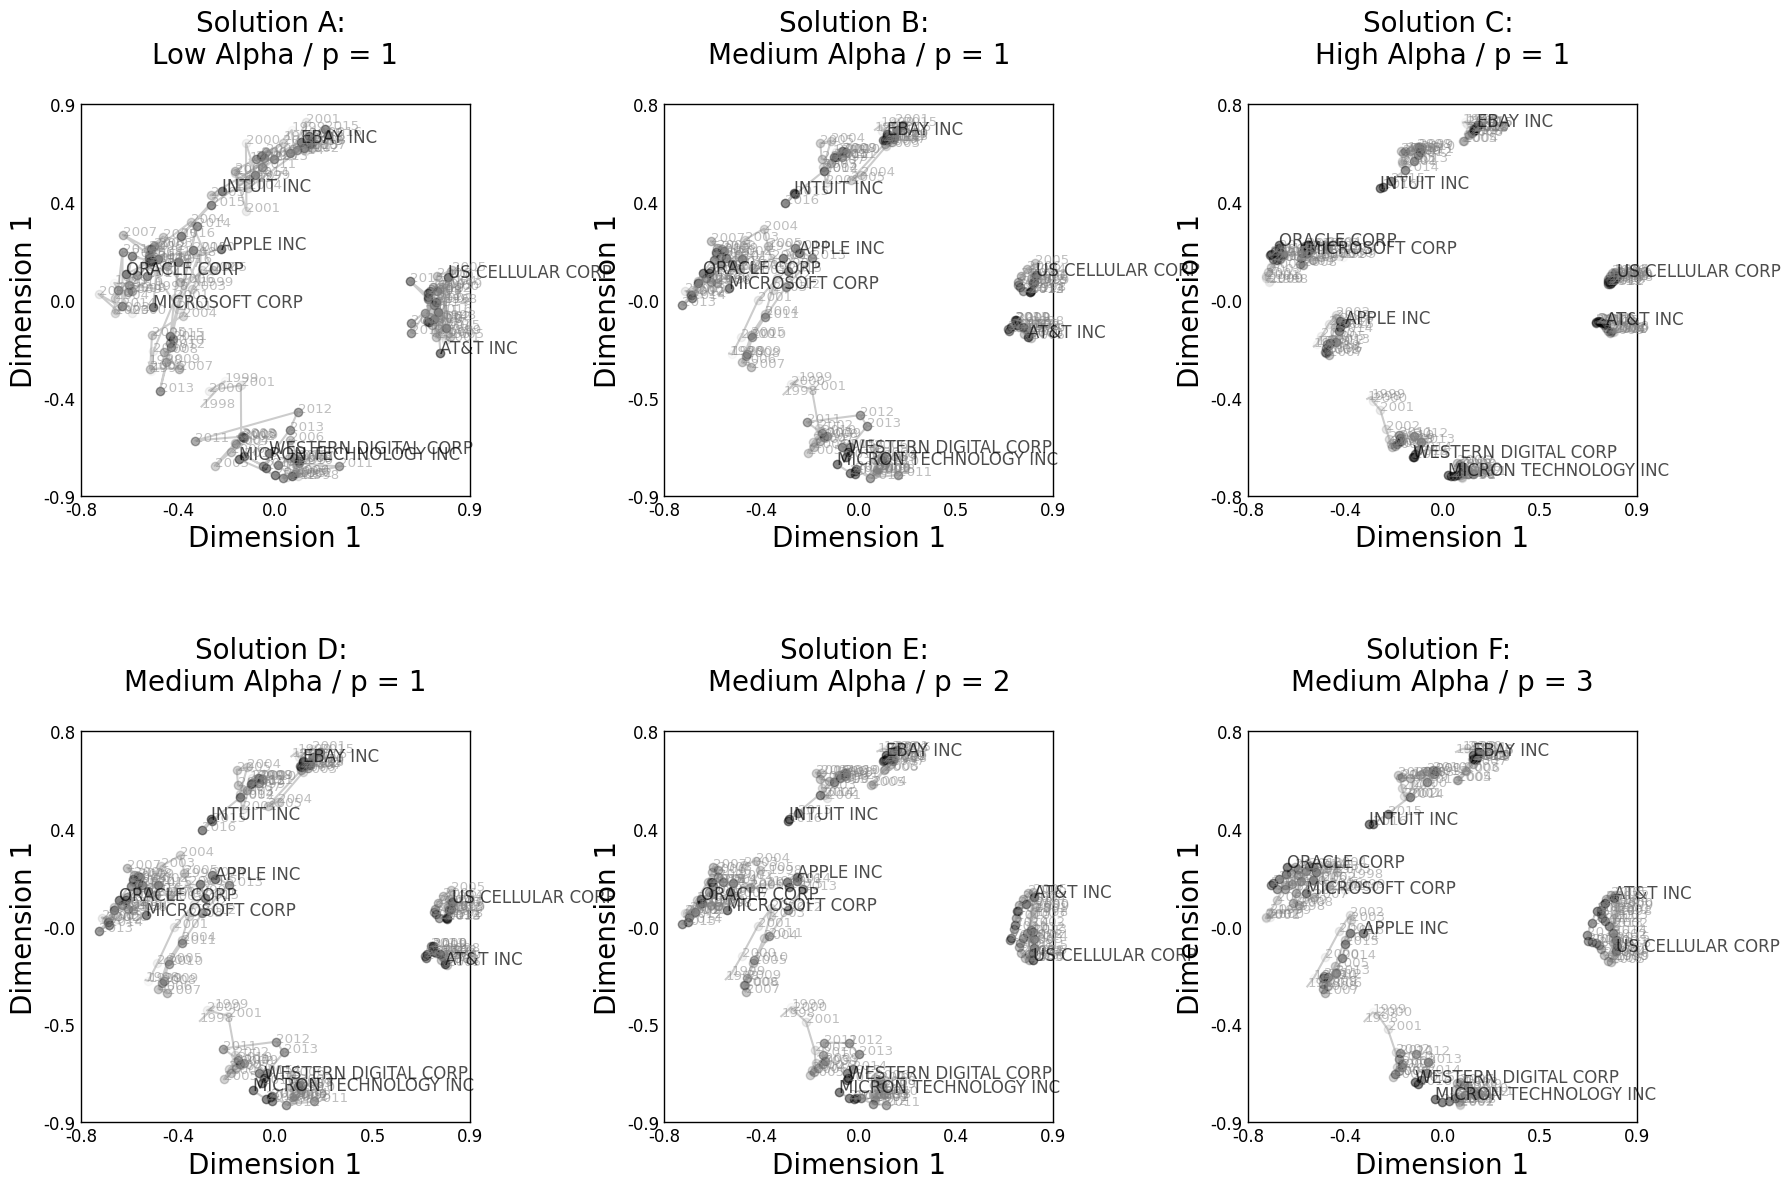

In [15]:
# A crucial task when running EvoMap is to find suitable values for its hyperparameters.
#
# Here, we illustrate the effect that varying values of these hyperparamters have on EvoMap's output:

# Varying levels of alpha:
X_t_low_alpha = EvoMDS(alpha = 0.01, mds_type = 'ordinal', init = cmds_t).fit_transform(D_t)
X_t_mid_alpha = EvoMDS(alpha = 0.2, mds_type = 'ordinal', init = cmds_t).fit_transform(D_t)
X_t_high_alpha = EvoMDS(alpha = 1.5, mds_type = 'ordinal', init = cmds_t).fit_transform(D_t)

# Varying levels of p:
X_t_p1 = EvoMDS(alpha = .2, p = 1, mds_type = 'ordinal', init = cmds_t).fit_transform(D_t)
X_t_p2 = EvoMDS(alpha = .2, p = 2, mds_type = 'ordinal', init = cmds_t).fit_transform(D_t)
X_t_p3 = EvoMDS(alpha = .2, p = 3, mds_type = 'ordinal', init = cmds_t).fit_transform(D_t)

# Plot results:

from evomap.printer import draw_trajectories
fig, ax = plt.subplots(2,3,figsize = (18,12))

draw_trajectories(X_t_low_alpha, show_axes= True, labels = labels, period_labels= periods, ax = ax[0,0])
draw_trajectories(X_t_mid_alpha, labels = labels, period_labels = periods, show_axes=True, ax = ax[0,1])
draw_trajectories(X_t_high_alpha, labels = labels, period_labels = periods, show_axes = True, ax = ax[0,2])

draw_trajectories(X_t_p1, show_axes= True, labels = labels, period_labels= periods, ax = ax[1,0])
draw_trajectories(X_t_p2, labels = labels, period_labels = periods, show_axes=True, ax = ax[1,1])
draw_trajectories(X_t_p3, labels = labels, period_labels = periods, show_axes = True, ax = ax[1,2])

ax[0,0].set_title('Solution A: \nLow Alpha / p = 1\n', fontdict = title_fontdict)
ax[0,1].set_title('Solution B: \nMedium Alpha / p = 1\n', fontdict = title_fontdict)
ax[0,2].set_title('Solution C: \nHigh Alpha / p = 1\n', fontdict = title_fontdict)
ax[1,0].set_title('Solution D: \nMedium Alpha / p = 1\n', fontdict = title_fontdict)
ax[1,1].set_title('Solution E: \nMedium Alpha / p = 2\n', fontdict = title_fontdict)
ax[1,2].set_title('Solution F: \nMedium Alpha / p = 3\n', fontdict = title_fontdict)

ax[0,0].set_xlabel('Dimension 1', fontdict = title_fontdict)
ax[0,1].set_xlabel('Dimension 1', fontdict = title_fontdict)
ax[0,2].set_xlabel('Dimension 1', fontdict = title_fontdict)
ax[1,0].set_xlabel('Dimension 1', fontdict = title_fontdict)
ax[1,1].set_xlabel('Dimension 1', fontdict = title_fontdict)
ax[1,2].set_xlabel('Dimension 1', fontdict = title_fontdict)

ax[0,0].set_ylabel('Dimension 1', fontdict = title_fontdict)
ax[0,1].set_ylabel('Dimension 1', fontdict = title_fontdict)
ax[0,2].set_ylabel('Dimension 1', fontdict = title_fontdict)
ax[1,0].set_ylabel('Dimension 1', fontdict = title_fontdict)
ax[1,1].set_ylabel('Dimension 1', fontdict = title_fontdict)
ax[1,2].set_ylabel('Dimension 1', fontdict = title_fontdict)
fig.tight_layout()
fig.subplots_adjust(
    hspace= .6,
    wspace = .5
)
fig.show()
if save_to:
    fig.savefig(os.path.join(PATH_OUT, 'Fig5_hyperparameters.PNG'), dpi = 300)

fig

## Convergence Diagnostics

In [16]:
# To obtain more details on how well the optimization converges, the user can change the 'verbose' parameter:

EvoMDS(
    alpha = .2,
    p = 2,
    mds_type = 'ordinal',
    init = cmds_t,
    verbose = 1).fit(D_t)

EvoMDS(
    alpha = .2,
    p = 2,
    mds_type = 'ordinal',
    init = cmds_t,
    n_iter_check = 50,
    verbose = 2).fit(D_t)

[EvoMDS] Running Gradient Descent with Backtracking via Halving
[EvoMDS] Iteration 535: gradient norm vanished. Final cost: 3.87
[EvoMDS] Running Gradient Descent with Backtracking via Halving
[EvoMDS] Iteration 50 -- Cost: 3.90 -- Gradient Norm: 0.0176
[EvoMDS] Iteration 100 -- Cost: 3.88 -- Gradient Norm: 0.0089
[EvoMDS] Iteration 150 -- Cost: 3.88 -- Gradient Norm: 0.0100
[EvoMDS] Iteration 200 -- Cost: 3.88 -- Gradient Norm: 0.0059
[EvoMDS] Iteration 250 -- Cost: 3.88 -- Gradient Norm: 0.0052
[EvoMDS] Iteration 300 -- Cost: 3.88 -- Gradient Norm: 0.0045
[EvoMDS] Iteration 350 -- Cost: 3.88 -- Gradient Norm: 0.0024
[EvoMDS] Iteration 400 -- Cost: 3.87 -- Gradient Norm: 0.0121
[EvoMDS] Iteration 450 -- Cost: 3.87 -- Gradient Norm: 0.0037
[EvoMDS] Iteration 500 -- Cost: 3.87 -- Gradient Norm: 0.0046
[EvoMDS] Iteration 535: gradient norm vanished. Final cost: 3.87


## Exploration

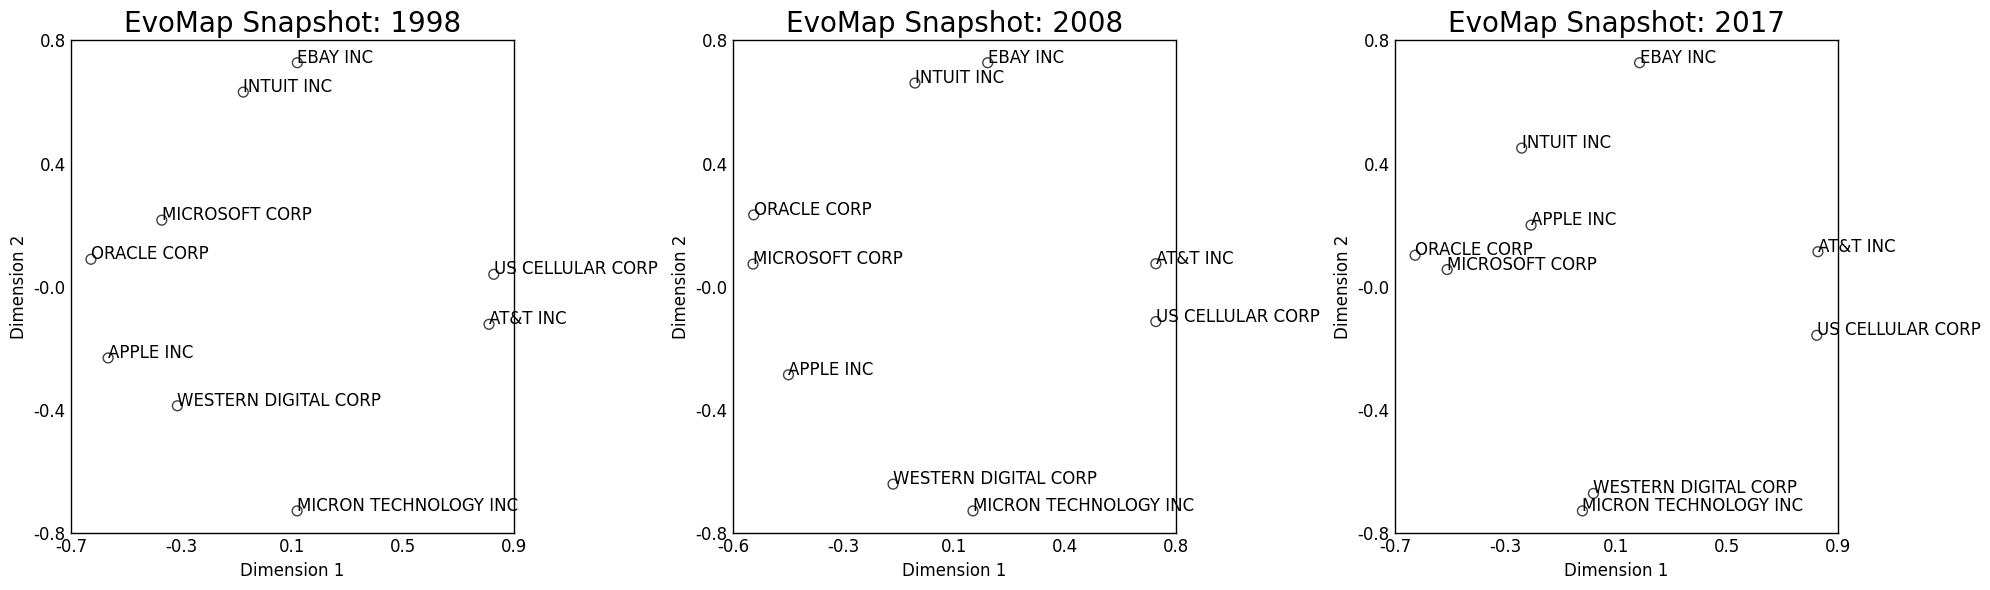

In [17]:
# Once EvoMap ran, the user can explore its output in either static or dynamic maps. The two main functions are:
# - draw_map
# - draw_dynamic_map

# #### Static Exploration via Draw Map

# Use static maps to compare snapshots
fig, ax = plt.subplots(1,3, figsize = (20,6))
draw_map(X_t[0], label = labels, ax = ax[0])
draw_map(X_t[10], label = labels, ax = ax[1])
draw_map(X_t[19], label = labels, ax = ax[2])

ax[0].set_title('EvoMap Snapshot: {0}'.format(periods[0]), **title_fontdict)
ax[1].set_title('EvoMap Snapshot: {0}'.format(periods[10]), **title_fontdict)
ax[2].set_title('EvoMap Snapshot: {0}'.format(periods[19]), **title_fontdict)

fig.tight_layout()
plt.show()
if save_to:
    fig.savefig(os.path.join(PATH_OUT, 'Fig6_static_snapshots.PNG'), dpi = 300)

fig

/tmp/ipython-input-18-4283238017.py:23: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


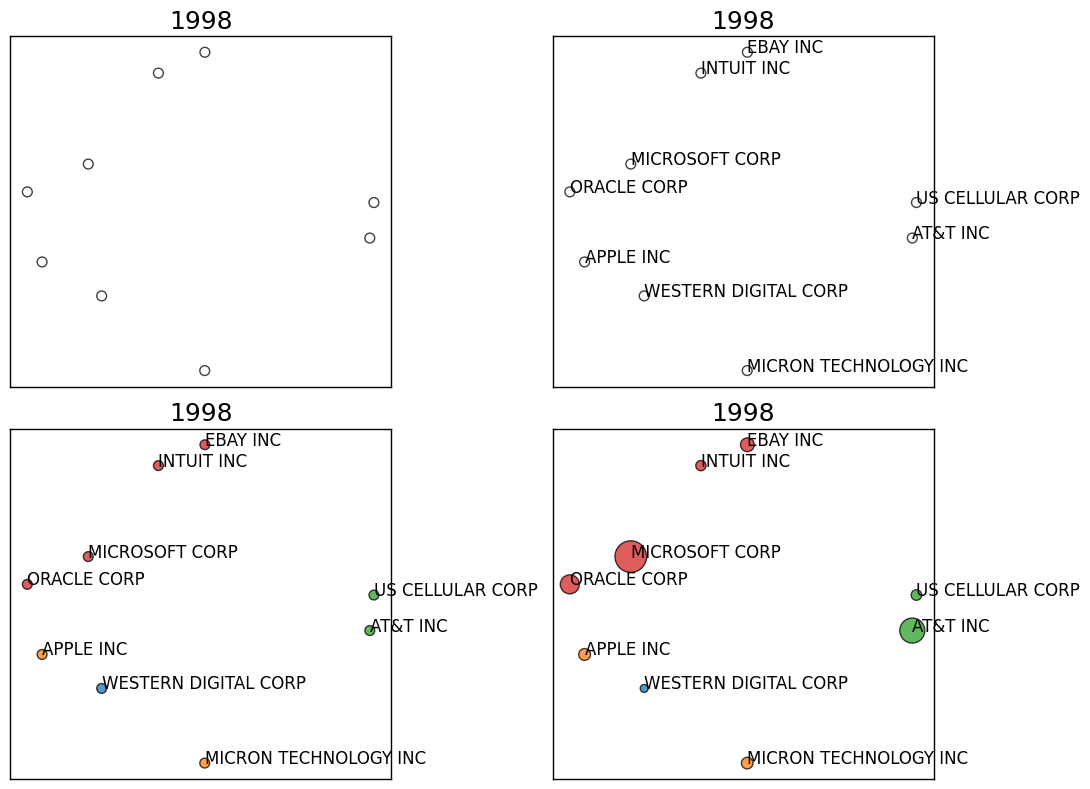

In [18]:
# Also, we can augment the maps by linking variables in our data to visual characteristics.
#
# For instance, we can color each point based on the firm's SIC code.

sic_codes = []
for firm in labels:
    sic_codes.append(data.query('name1 == @firm').sic1.unique()[0])

# Or, we can adjust the size of each point proportional to the firm's market value:
sizes = []
for firm in labels:
    sizes.append(data.query('name1 == @firm').size1.unique()[0].round(2))

# Such variables can be added to the map via the 'c' and 'size' arguments:
sic = data.sic1

fig, ax = plt.subplots(2,2,figsize = (11,8), layout = 'constrained')
draw_map(X_t[0], show_axes = False, title = periods[0], ax = ax[0,0])
draw_map(X_t[0], label = labels, show_axes = False, title = periods[0], ax = ax[0,1])
draw_map(X_t[0], label = labels, show_axes = False, color = sic_codes, show_legend = False, title = periods[0], ax = ax[1,0])
draw_map(X_t[0], label = labels, color = sic_codes, size = sizes, show_axes=False,
title = periods[0], ax = ax[1,1])
fig.tight_layout()
plt.show()
if save_to:
    fig.savefig(os.path.join(PATH_OUT, 'Fig7_draw_map_illustrations.PNG'), dpi = 300)

fig

## Drawing Dynamic Maps


In [19]:
# Beyond individual snapshots, evomap allows to create dynamic maps, overlaying multiple
# snapshots to illustrate changes over time. This is accomplished with draw_dynamic_map()
# or draw_trajectories().

# ### Dynamic Map
#
# Before we draw the map, we store the additional variables linked to color and size:
sic_codes_t = []
sizes_t = []
for t in range(n_periods):
    data_this = data.query('year == @periods[@t]')
    sic_this = []
    for firm in labels:
        sic_this.append(data_this.query('name1 == @firm').sic1.unique()[0])

    sic_codes_t.append(np.array(sic_this))

    sizes_this = []
    for firm in labels:
        sizes_this.append(data_this.query('name1 == @firm').size1.unique()[0])

    sizes_t.append(np.array(sizes_this))

# We then draw the map, using these variabels as additional aesthetics:
fig, ax = plt.subplots(1,2, figsize = (16,7))

from evomap.printer import draw_dynamic_map
draw_dynamic_map(X_t,
                 label = labels,
                 color_t = sic_codes_t,
                 size_t = sizes_t,
                 show_arrows = True,
                 show_axes = True,
                 ax = ax[0])

### Draw Trajectories


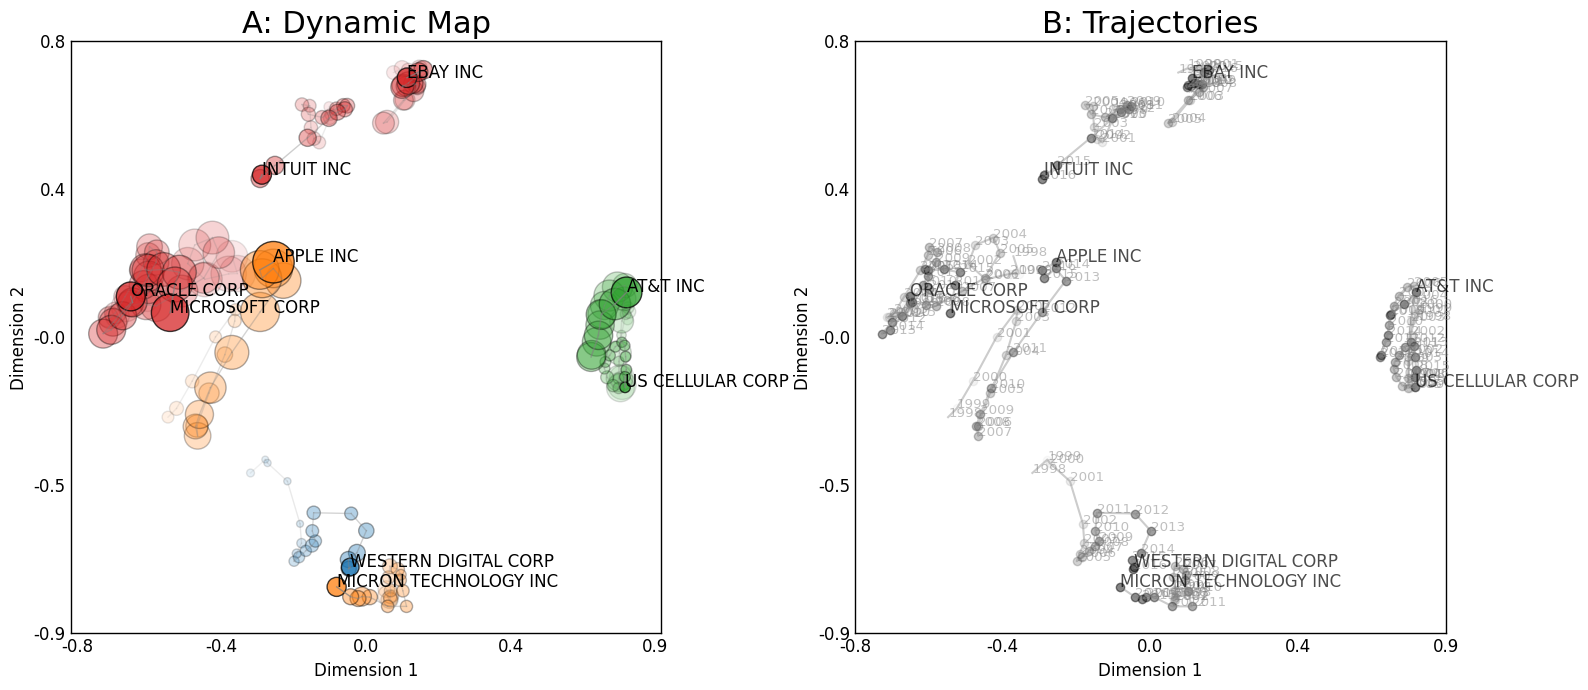

In [20]:
# Alternatively, draw_trajectories focuses solely on all objects' movement paths:
from evomap.printer import draw_trajectories
draw_trajectories(X_t,
                  labels = labels,
                  period_labels = periods,
                  show_axes=True,
                  ax = ax[1])

ax[0].set_title('A: Dynamic Map')
ax[1].set_title('B: Trajectories')

fig.tight_layout()
plt.show()
if save_to:
    fig.savefig(os.path.join(PATH_OUT, 'Fig8_dynamic_map_and_trajectories.PNG'), dpi = 300)

fig

## Evaluation

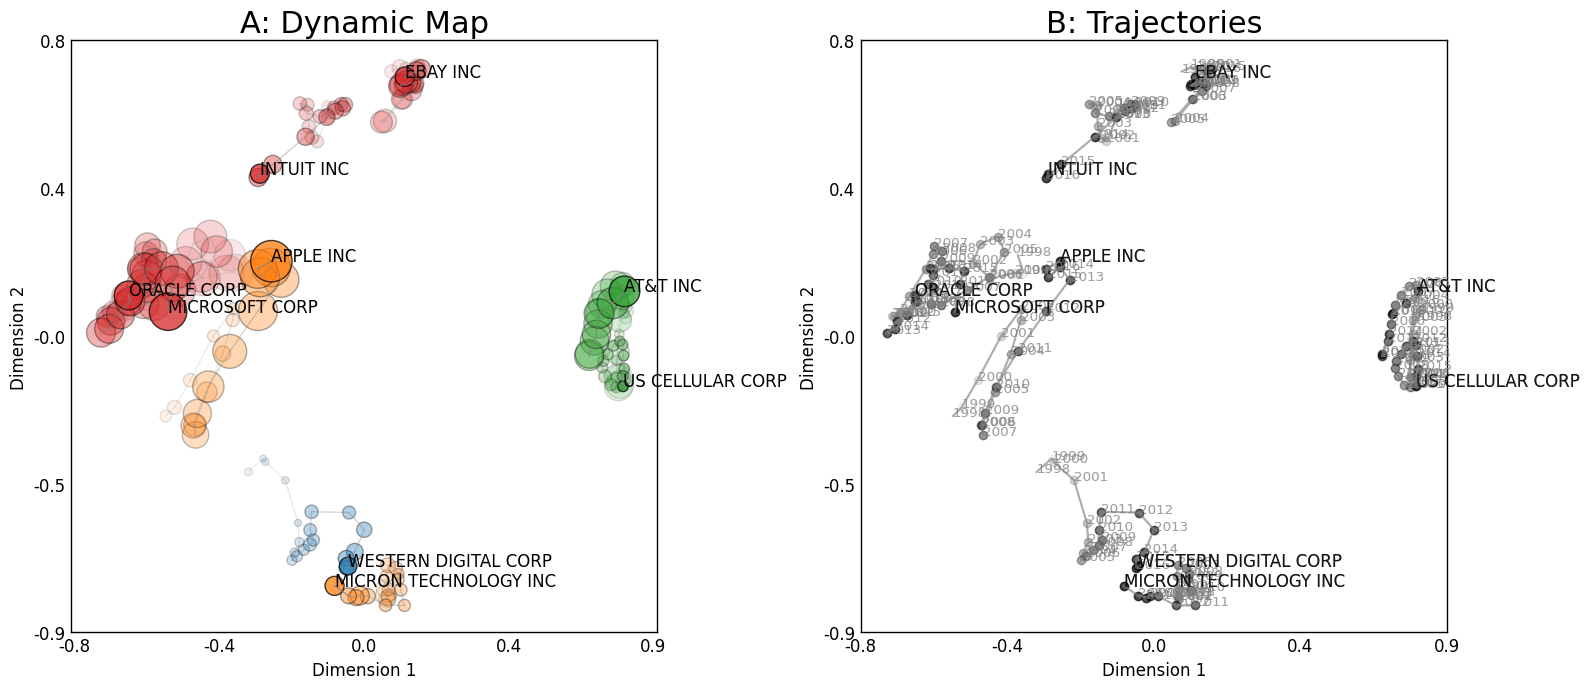

In [21]:
# Alternatively, draw_trajectories focuses solely on all objects' movement paths:
from evomap.printer import draw_trajectories
draw_trajectories(X_t,
                  labels = labels,
                  period_labels = periods,
                  show_axes=True,
                  ax = ax[1])

ax[0].set_title('A: Dynamic Map')
ax[1].set_title('B: Trajectories')

fig.tight_layout()
plt.show()
if save_to:
    fig.savefig(os.path.join(PATH_OUT, 'Fig8_dynamic_map_and_trajectories.PNG'), dpi = 300)

fig

## Evaluation

In [22]:
# While visual exploration allows to explore the mapping results, it is essential to evalute how
# well they represent the underlying data. This can be achieved through:

# ### Cost Function Values
cmds_indep = []
for t in range(n_periods):
  cmds_indep.append(CMDS().fit_transform(D_t[t]))

evomds_indep = EvoMDS(
    alpha = 0,
    init = cmds_indep,
    mds_type= 'ordinal').fit(D_t)

print(evomds_indep.cost_static_avg_.round(4))
print(evomds.cost_static_avg_.round(4))

# ### Evaluation Metrics
from evomap.metrics import *
print(misalign_score(X_t).round(4))
print(persistence_score(X_t).round(4))

0.1875
0.1911
0.0468
0.6484


In [23]:
# For comparison, we also compute these metrics for two additional solutions:
# - Independent Mapping
# - Independent Mapping, aligned via Procrustes Analysis

from evomap.transform import align_maps
X_t_indep = EvoMDS(alpha = 0, mds_type = 'ordinal', init = cmds_indep).fit_transform(D_t)
X_t_indep_aligned = align_maps(X_t_indep, X_t[0])

# Overview of all results:
from evomap.metrics import *

misalign_score_t = []
persistence_score_t = []

for i, X in enumerate([X_t, X_t_indep, X_t_indep_aligned]):
    misalign_score_t.append(misalign_score(X))
    persistence_score_t.append(persistence_score(X))

metrics = pd.DataFrame({'misalign_score': misalign_score_t,
                        'persistence_score': persistence_score_t},
                          index = ['EvoMDS', 'Independent MDS', 'Independent MDS + Alignment'])

metrics['average_stress'] = [evomds.cost_static_avg_, evomds_indep.cost_static_avg_, evomds_indep.cost_static_avg_]

# sort metrics such that the order is Independent MDS, Independent MDS + Alignment, EvoMDS
metrics = metrics.reindex(['Independent MDS', 'Independent MDS + Alignment', 'EvoMDS'])
print(metrics.round(4))

                             misalign_score  persistence_score  average_stress
Independent MDS                      0.9737            -0.5589          0.1875
Independent MDS + Alignment          0.3074            -0.2718          0.1875
EvoMDS                               0.0468             0.6484          0.1911


## Hyperparameter Tuning


In [24]:
# To facilitate finding good hyperparameters, evomap allows the user to conduct a grid search over a
# range of hyperparameter values.

# ### Using the Grid Search

# First, define the parameter space across which the grid search shall be completed

param_grid = {
    'alpha': np.linspace(0, 1.5, 15),
    'p': [1,2]}

# Next, define the metrics on which each parameter combination is to be evaluated

from evomap.metrics import misalign_score, persistence_score, avg_hitrate_score
metrics = [misalign_score, persistence_score, avg_hitrate_score]
metric_labels = ['Misalignment', 'Persistence', 'Hitrate']

[EvoMDS] Diverging gradient norm at iteration 211
[EvoMDS] Adjusting step sizes..
[EvoMDS] Diverging gradient norm at iteration 99
[EvoMDS] Adjusting step sizes..
[EvoMDS] Diverging gradient norm at iteration 69
[EvoMDS] Adjusting step sizes..
[EvoMDS] Diverging gradient norm at iteration 54
[EvoMDS] Adjusting step sizes..
[EvoMDS] Diverging gradient norm at iteration 46
[EvoMDS] Adjusting step sizes..
Grid results:
          p  cost_static_avg  Misalignment  Persistence  Hitrate
alpha                                                           
0.000000  1         0.184808      0.145132    -0.471110      0.9
0.000000  2         0.184808      0.145132    -0.471110      0.9
0.107143  1         0.184993      0.073288     0.014034      0.9
0.107143  2         0.189304      0.052314     0.501950      0.9
0.214286  1         0.187064      0.057209     0.240635      0.9


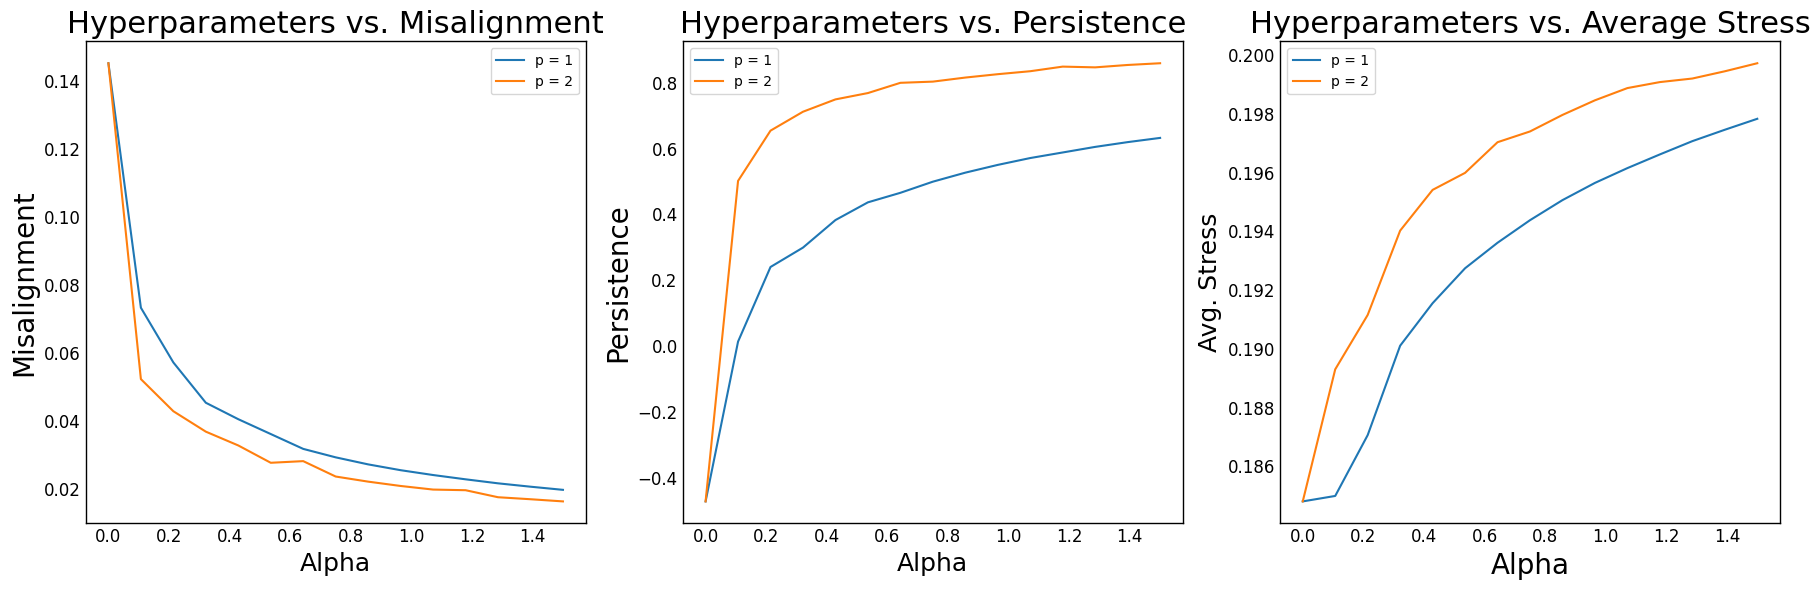

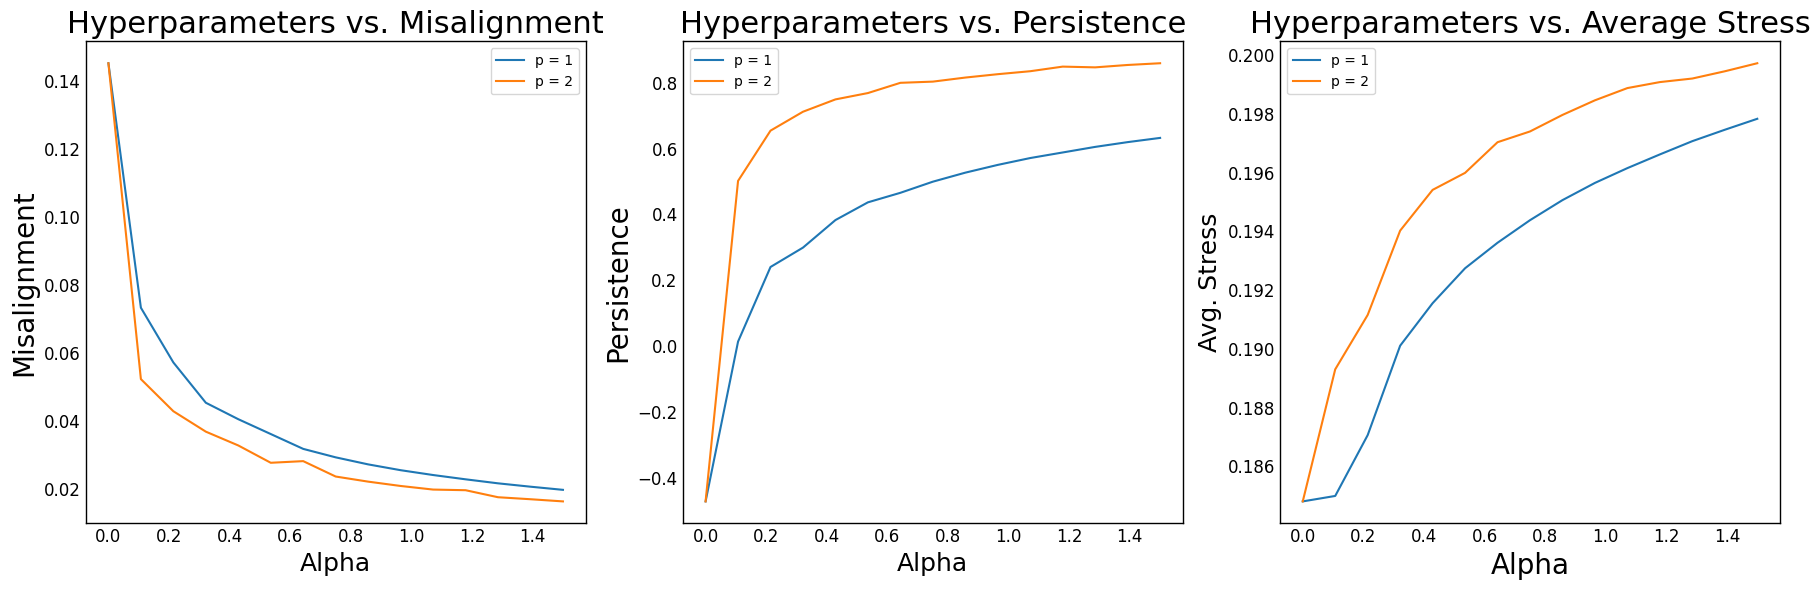

In [25]:
# Then, perform the grid search:
model = EvoMDS(init = cmds_t, mds_type = 'ordinal')

df_grid_results = model.grid_search(
    Xs = D_t,
    param_grid = param_grid,
    eval_functions =  metrics,
    eval_labels = metric_labels,
    kwargs = {"input_format" : 'dissimilarity'})

# View the results:
print("Grid results:")
print(df_grid_results.head())
fig, ax = plt.subplots(1,3, figsize = (18, 6))
df_grid_results.groupby('p')['Misalignment'].plot(legend = True, ax = ax[0])
df_grid_results.groupby('p')['Persistence'].plot(legend = True, ax = ax[1])
df_grid_results.groupby('p')['cost_static_avg'].plot(legend = True, ax = ax[2])

ax[0].set_title('Hyperparameters vs. Misalignment', fontdict = title_fontdict_large)
ax[0].set_xlabel('Alpha', fontdict = label_fontdict)
ax[0].set_ylabel('Misalignment', fontdict = label_fontdict_large)
ax[0].legend(labels = ['p = 1', 'p = 2'])
ax[1].set_title('Hyperparameters vs. Persistence', fontdict = title_fontdict_large)
ax[1].set_xlabel('Alpha', fontdict = label_fontdict)
ax[1].set_ylabel('Persistence', fontdict = label_fontdict_large)
ax[1].legend(labels = ['p = 1', 'p = 2'])
ax[2].set_title('Hyperparameters vs. Average Stress', fontdict = title_fontdict_large)
ax[2].set_xlabel('Alpha', fontdict = label_fontdict_large)
ax[2].set_ylabel('Avg. Stress', fontdict = label_fontdict)
ax[2].legend(labels = ['p = 1', 'p = 2'])

fig.tight_layout()
if save_to:
    fig.savefig(os.path.join(PATH_OUT, 'Fig9_grid_search.PNG'), dpi = 300)

fig

## Unbalanced Data

(9, 9)
(10, 10)
(10, 10)
[1 1 1 1 1 1 1 1 1 0]
[1 1 1 1 1 1 1 1 1 1]
[EvoMDS] Running Gradient Descent with Backtracking via Halving
[EvoMDS] Iteration 50 -- Cost: 4.85 -- Gradient Norm: 0.0694
[EvoMDS] Iteration 100 -- Cost: 4.61 -- Gradient Norm: 0.0285
[EvoMDS] Iteration 150 -- Cost: 4.54 -- Gradient Norm: 0.0220
[EvoMDS] Iteration 200 -- Cost: 4.49 -- Gradient Norm: 0.0157
[EvoMDS] Iteration 250 -- Cost: 4.47 -- Gradient Norm: 0.0107
[EvoMDS] Iteration 300 -- Cost: 4.46 -- Gradient Norm: 0.0072
[EvoMDS] Iteration 350 -- Cost: 4.45 -- Gradient Norm: 0.0050
[EvoMDS] Iteration 400 -- Cost: 4.44 -- Gradient Norm: 0.0070
[EvoMDS] Iteration 450 -- Cost: 4.44 -- Gradient Norm: 0.0053
[EvoMDS] Iteration 500 -- Cost: 4.43 -- Gradient Norm: 0.0050
[EvoMDS] Iteration 550 -- Cost: 4.43 -- Gradient Norm: 0.0039
[EvoMDS] Iteration 600 -- Cost: 4.43 -- Gradient Norm: 0.0028
[EvoMDS] Iteration 650 -- Cost: 4.42 -- Gradient Norm: 0.0031
[EvoMDS] Iteration 700 -- Cost: 4.42 -- Gradient Norm: 0.0022


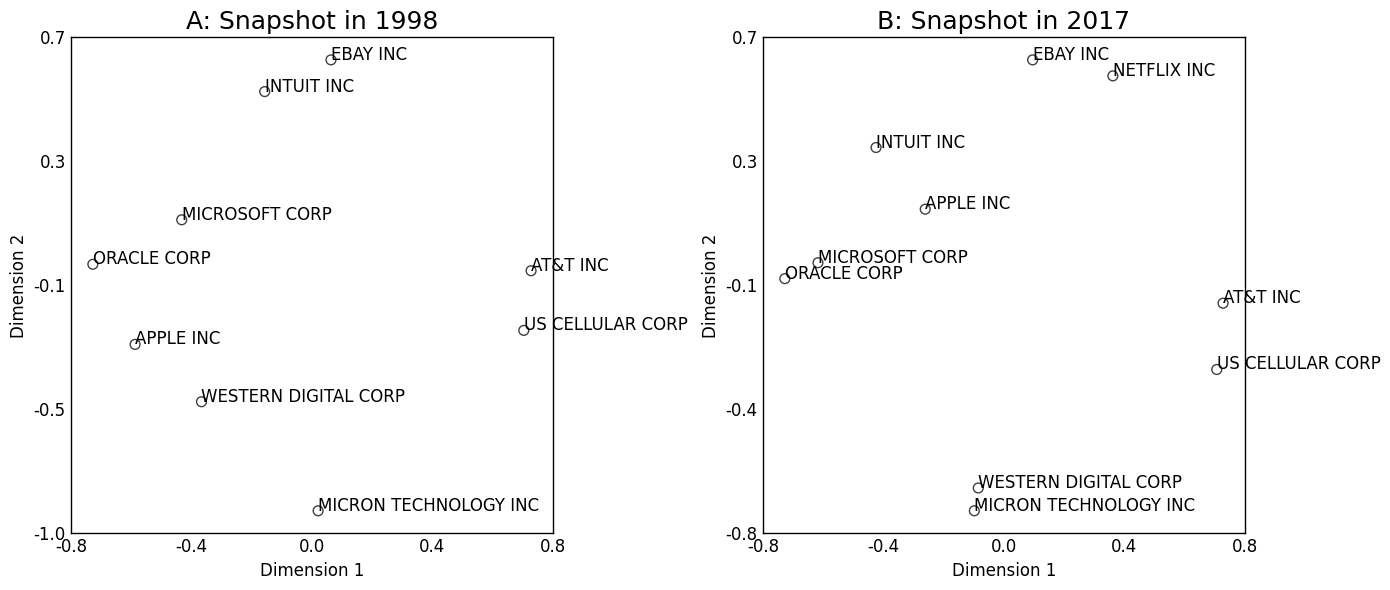

In [26]:
# Dynamic mapping often encounters scenarios where the set of objects changes over time, such
# as firms entering or exiting a market. The evomap package accommodates such unbalanced
# data through inclusion vectors.
#
# First, we load an unbalanced sample for this illustration:

data_unbalanced = load_tnic_sample_tech(unbalanced = True)
data_unbalanced.groupby('name1').agg({'year': 'nunique'})

# Then, transform the edgelist into a sequence of square matrices:
from evomap.preprocessing import edgelist2matrices
S_t, labels = edgelist2matrices(
    data_unbalanced,
    score_var='score',
    id_var_i='name1',
    id_var_j='name2',
    time_var = 'year')

# As the sample was unbalanced, the resultant matrices have unequal shape:
print(S_t[0].shape)
print(S_t[-1].shape)

# Thus, we next expand the matrices to a common shape:
from evomap.preprocessing import expand_matrices
S_t, inc_t, labels = expand_matrices(S_t, labels)
print(S_t[0].shape)

# The inclusion vectors indicate which objects will be considered by the mapping algorithm in each period:
print(inc_t[0])
print(inc_t[-1])

# Once the matrices are prepared, we can continue to transform them into dissimilarities as before:
D_t = []
for S in S_t:
    D = sim2diss(S, transformation='mirror')
    D_t.append(D)

# We define starting positions:
init_t = [np.concatenate([cmds, np.array([[0,0]])], axis = 0) for cmds in cmds_t]

# And run EvoMap, passing the inclusion vectors to fit_transform:
from evomap.mapping import EvoMDS
X_t = EvoMDS(alpha = 0.75,
             p = 2,
             mds_type = 'ordinal',
             init = init_t,
             verbose=2).fit_transform(D_t, inclusions = inc_t)

# Finally, we visualize the results in two snapshots.
#
# The left snapshot does not include Netflix, which only entered the sample during the observation period, while the right
# snapshot includes the newly entered firm.
from matplotlib import pyplot as plt
from evomap.printer import draw_map
fig, ax = plt.subplots(1,2,figsize=(14, 6))
draw_map(X_t[0],
         inclusions = inc_t[0],
         label = labels,
         ax = ax[0],
         show_axes=True,
         title = 'A: Snapshot in {0}'.format(periods[0]))
draw_map(X_t[-1],
         inclusions = inc_t[-1],
         label = labels,
         ax = ax[1],
         show_axes = True,
         title = 'B: Snapshot in {0}'.format(periods[-1]))
fig.tight_layout()
if save_to:
    fig.savefig(os.path.join(PATH_OUT, 'Fig10_unbalanced.PNG'), dpi = 300)

fig

# Further Ressources


In [27]:
# For further usage examples, based on a larger dataset, see https://evomap.readthedocs.io/en/latest/dynamic_mapping.html
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time:.2f} seconds")

Execution time: 596.52 seconds
